In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# No truncation of column content
pd.set_option('display.max_colwidth', None)  

import matplotlib.pyplot as plt
import seaborn as sns

FileOut = '../output/'

### Загружаем сырые данные

In [13]:
# List files available
print(os.listdir('../../Kaggle/home-credit-default-risk/input/'))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'HomeCredit_columns_description.ods', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [14]:
# 1.1 Training data
app_train = pd.read_csv('../../Kaggle/home-credit-default-risk/input/application_train.csv')
print('Training data shape: ', app_train.shape)
# app_train.sample(3)
print(app_train.dtypes.value_counts())
print(f"доля пустых значений: {app_train.isnull().sum().sum() / app_train.size}")

Training data shape:  (307511, 122)
float64    65
int64      41
object     16
Name: count, dtype: int64
доля пустых значений: 0.24395941907129431


In [15]:
# 1.2 Test data
app_test = pd.read_csv('../../Kaggle/home-credit-default-risk/input/application_test.csv')
print('Test data shape: ', app_test.shape)
# app_test.sample(3)

Test data shape:  (48744, 121)


In [16]:
targets = app_train['TARGET'].value_counts()
print(f'количество кредитов без просрочек в {targets[0]/targets[1]: .0f} раз превышает количество кредитов с просрочками, т.е. тренировочная выборка не сбалансирована')

количество кредитов без просрочек в  11 раз превышает количество кредитов с просрочками, т.е. тренировочная выборка не сбалансирована


In [17]:
# 2 bureau_df data
bureau_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/bureau.csv')
print('Test data shape: ', bureau_df.shape)
# bureau_df.sample(3)

Test data shape:  (1716428, 17)


In [18]:
# 3 bureau_balance data
bureau_balance_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/bureau_balance.csv')
print('Test data shape: ', bureau_balance_df.shape)
# bureau_balance_df.sample(1)

Test data shape:  (27299925, 3)


In [19]:
# 4 POS_CASH_balance data
POS_CASH_balance_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/POS_CASH_balance.csv')
print('Test data shape: ', POS_CASH_balance_df.shape)
# POS_CASH_balance_df.sample(1)

Test data shape:  (10001358, 8)


In [20]:
# 5 credit_card_balance data
credit_card_balance_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/credit_card_balance.csv')
print('credit_card_balance data shape: ', credit_card_balance_df.shape)
# credit_card_balance_df.sample(1)

credit_card_balance data shape:  (3840312, 23)


In [21]:
# 6 previous_application data
previous_application_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/previous_application.csv')
print('previous_application data shape: ', previous_application_df.shape)
# previous_application_df.sample(1)

previous_application data shape:  (1670214, 37)


In [22]:
# 7 installments_payments data
installments_payments_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/installments_payments.csv')
print('installments_payments shape: ', installments_payments_df.shape)
# installments_payments_df.sample(1)

installments_payments shape:  (13605401, 8)


In [23]:
# 8 метаданные
columns_description_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/HomeCredit_columns_description.csv',index_col=0, encoding='latin1')
print('installments_payments shape: ', columns_description_df.shape)
# columns_description_df.sample(1)

installments_payments shape:  (219, 4)


### Функции

In [24]:
# функция саммаризирует датасет (количество пропущенных и уникательных значений, тип данных)
def summarize_df(df):
    df_info = pd.DataFrame({
    "DataType": df.dtypes,
    "MissingValues": df.isnull().sum(),
    "UniqueValues": df.nunique()
    }).sort_values(by="MissingValues", ascending=False)
    df_info['MissingValuesRatio'] = round(df_info['MissingValues'] / len(df),2)
         
    return df_info

In [25]:
# типизация колонок датафрейма
def columns_types_assumption(df):
    binary_cols = [cname for cname in df.columns if
                    df[cname].nunique() <= 2 and 
                    df[cname].dtype in ['int64', 'object','bool','float64']]

    categorical_cols = [cname for cname in df.columns if
                    df[cname].nunique() < 12 and df[cname].nunique() > 2 and
                    df[cname].dtype in ['object']]

    numerical_cols = [cname for cname in df.columns if 
                df[cname].dtype in ['int64', 'float64'] and df[cname].nunique() > 2]

    return binary_cols, categorical_cols, numerical_cols

In [26]:
# функция исключает аномалии методом 3-сигм
def cap_outliers_3sigma(df, columns):
    """
    Caps values in specified columns at the 3-sigma threshold and calculates the percentage of outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to cap.
    
    Returns:
        pd.DataFrame: DataFrame with capped values.
        pd.Series: Percentage of outliers for each column.
    """
    df_capped = df.copy()
    outlier_percentages = {}

    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std

        # Calculate outlier percentage
        num_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_percentages[col] = (num_outliers / len(df)) * 100

        # Apply capping
        df_capped[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    return df_capped, pd.Series(outlier_percentages, name="Outlier Percentage")

In [27]:
# функция исключает аномалии методом 3-сигм
def cap_outliers_3sigma(df, columns):
    """
    Caps values in specified columns at the 3-sigma threshold and calculates the percentage of outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to cap.
    
    Returns:
        pd.DataFrame: DataFrame with capped values.
        pd.Series: Percentage of outliers for each column.
    """
    df_capped = df.copy()
    outlier_percentages = {}

    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std

        # Calculate outlier percentage
        num_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_percentages[col] = (num_outliers / len(df)) * 100

        # Apply capping
        df_capped[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    return df_capped, pd.Series(outlier_percentages, name="Outlier Percentage")

### Основной датасет applications

In [28]:
if 'app_train' in locals():
    del(app_train)

if 'app_test' in locals():
    del(app_test)

app_train = pd.read_csv('../../Kaggle/home-credit-default-risk/input/application_train.csv')

<Axes: >

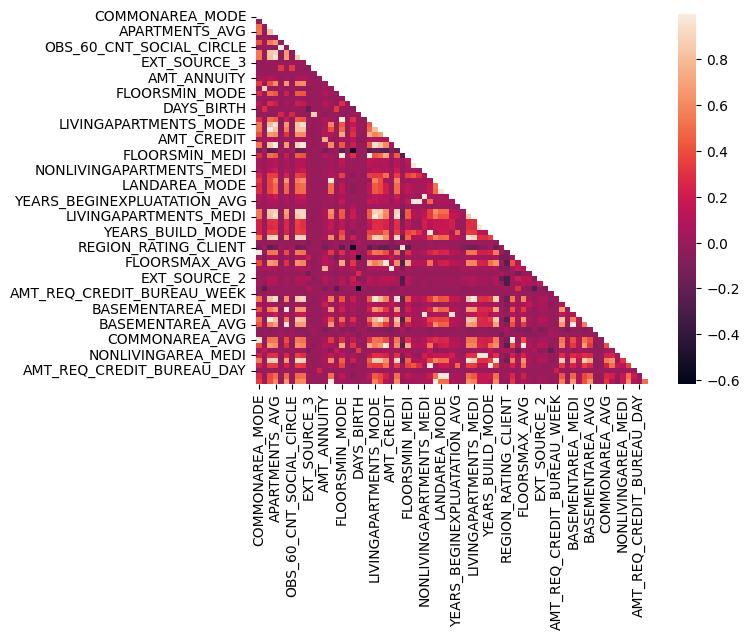

In [29]:
# корреляции признаков в основном датасете
binary_cols_proposal, categorical_cols_proposal, numerical_cols_proposal = columns_types_assumption(app_train)
corr_columns = list(set(numerical_cols_proposal)-set(['TARGET','SK_ID_CURR']))
corr_matrix = app_train[corr_columns].corr(numeric_only = True, method='pearson')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,mask=mask)

In [30]:
# credit ratios
app_train_orig = app_train.copy()
app_train_orig['APPS_ANNUITY_CREDIT_RATIO'] = app_train_orig['AMT_ANNUITY']/app_train_orig['AMT_CREDIT']
app_train_orig['APPS_EXT_SOURCE_MEAN'] = app_train_orig[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
app_train_orig['APPS_EXT_SOURCE_STD'] = app_train_orig[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
app_train_orig['APPS_EXT_SOURCE_STD'] = app_train_orig['APPS_EXT_SOURCE_STD'].fillna(app_train_orig['APPS_EXT_SOURCE_STD'].mean())
app_train_orig['APPS_GOODS_CREDIT_RATIO'] = app_train_orig['AMT_GOODS_PRICE']/app_train_orig['AMT_CREDIT']
app_train_orig['APPS_ANNUITY_INCOME_RATIO'] = app_train_orig['AMT_ANNUITY']/app_train_orig['AMT_INCOME_TOTAL']
app_train_orig['APPS_INCOME_EMPLOYED_RATIO'] = app_train_orig['AMT_INCOME_TOTAL']/app_train_orig['DAYS_EMPLOYED']
app_train_orig['APPS_EMPLOYED_BIRTH_RATIO'] = app_train_orig['DAYS_EMPLOYED']/app_train_orig['DAYS_BIRTH']

app_train_orig['APPS_CAR_EMPLOYED_RATIO'] = app_train_orig['OWN_CAR_AGE'] / app_train_orig['DAYS_EMPLOYED']
app_train_orig['APPS_INCOME_BIRTH_RATIO'] = app_train_orig['AMT_INCOME_TOTAL']/app_train_orig['DAYS_BIRTH']

app_columns = app_train_orig.columns

In [31]:
app_train_orig.isna().sum().sum() / app_train_orig.size

0.2322480811894745

### Бюро кредитных историй bureau_df

In [32]:
# difference and date ratio between the planned debt start and completion date and the actual debt completion date
bureau_df['BUREAU_ENDDATE_FACT_DIFF'] = bureau_df['DAYS_CREDIT_ENDDATE'] - bureau_df['DAYS_ENDDATE_FACT']
bureau_df['BUREAU_CREDIT_FACT_DIFF'] = bureau_df['DAYS_CREDIT'] - bureau_df['DAYS_ENDDATE_FACT']
bureau_df['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau_df['DAYS_CREDIT'] - bureau_df['DAYS_CREDIT_ENDDATE']

bureau_df['BUREAU_CREDIT_DEBT_RATIO']=bureau_df['AMT_CREDIT_SUM_DEBT']/bureau_df['AMT_CREDIT_SUM']
bureau_df['BUREAU_CREDIT_DEBT_DIFF'] = bureau_df['AMT_CREDIT_SUM_DEBT'] - bureau_df['AMT_CREDIT_SUM']

bureau_df['BUREAU_IS_DPD'] = bureau_df['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
bureau_df['BUREAU_IS_DPD_OVER120'] = bureau_df['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)

In [33]:
# аггрегированные показатели
bureau_agg_dict = {
'SK_ID_BUREAU':['count'],
'DAYS_CREDIT':['min', 'max', 'mean'],
'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
'AMT_ANNUITY': ['max', 'mean', 'sum'],

'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
'BUREAU_IS_DPD':['mean', 'sum'],
'BUREAU_IS_DPD_OVER120':['mean', 'sum']
}

bureau_grp = bureau_df.groupby('SK_ID_CURR')
bureau_amt_agg = bureau_grp.agg(bureau_agg_dict)
bureau_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_amt_agg.columns.ravel()]
bureau_amt_agg = bureau_amt_agg.reset_index()

In [34]:
bureau_amt_agg_cols = bureau_amt_agg.columns

In [35]:
# аггрегированные, касающиеся только активных кредитов  
cond_active = bureau_df['CREDIT_ACTIVE'] == 'Active'
bureau_active_grp = bureau_df[cond_active].groupby(['SK_ID_CURR'])
bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],    
    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }
bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
bureau_active_agg = bureau_active_agg.reset_index()

In [36]:
bureau_active_agg_cols = bureau_active_agg.columns
bureau_active_agg.dtypes.value_counts()

float64    39
int64       8
Name: count, dtype: int64

In [37]:
len(bureau_active_agg_cols)

47

### Предыдущие заявки previous_application_df

In [38]:
# кредитные показатели для предыдущих заявок
previous_application_df['PREV_CREDIT_DIFF'] = previous_application_df['AMT_APPLICATION'] - previous_application_df['AMT_CREDIT']
previous_application_df['PREV_GOODS_DIFF'] = previous_application_df['AMT_APPLICATION'] - previous_application_df['AMT_GOODS_PRICE']
previous_application_df['PREV_CREDIT_APPL_RATIO'] = previous_application_df['AMT_CREDIT']/previous_application_df['AMT_APPLICATION']
previous_application_df['PREV_GOODS_APPL_RATIO'] = previous_application_df['AMT_GOODS_PRICE']/previous_application_df['AMT_APPLICATION']

# процентная ставка
previous_application_df['all_pay'] = previous_application_df['AMT_ANNUITY'] * previous_application_df['CNT_PAYMENT']
previous_application_df['PREV_INTERESTS_RATE'] = (previous_application_df['all_pay']/previous_application_df['AMT_CREDIT'] - 1)/previous_application_df['CNT_PAYMENT']

In [39]:
# аггрегированные показатели
agg_dict = {    
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
    'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
    'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
    'PREV_GOODS_APPL_RATIO':['mean', 'max'],    
    'PREV_INTERESTS_RATE':['mean', 'max']
}

previous_application_group_df = previous_application_df.groupby('SK_ID_CURR')
previous_amt_agg = previous_application_group_df.agg(agg_dict)
previous_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in previous_amt_agg.columns.ravel()]

In [40]:
# аггрегированные показатели отказов
prev_refused_appr_group = previous_application_df[previous_application_df['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
# unstack() 
prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()

# rename column 
prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)

# prev_refused_appr_agg

In [41]:
# соединяем агрегированные таблицы
prev_agg = previous_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)

In [42]:
prev_agg_cols = prev_agg.columns
# prev_agg_cols

### Соединяем в один датасет

In [43]:
print('original dataset shape:', app_train.shape)
print('extended dataset shape:', app_train_orig.shape)

apps_all = app_train_orig.merge(prev_agg, on='SK_ID_CURR', how='left')
print('apps_all after merge with prev_agg shape:', apps_all.shape)
apps_all = apps_all.merge(bureau_amt_agg, on='SK_ID_CURR', how='left')
print('apps_all after merge with bureau_amt_agg shape:', apps_all.shape)
apps_all = apps_all.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
print('apps_all after merge with bureau_active_agg shape:', apps_all.shape)

original dataset shape: (307511, 122)
extended dataset shape: (307511, 131)
apps_all after merge with prev_agg shape: (307511, 168)
apps_all after merge with bureau_amt_agg shape: (307511, 214)
apps_all after merge with bureau_active_agg shape: (307511, 260)


In [44]:
apps_all.isna().sum().sum() / apps_all.size

0.24702863662413077

### Предварительные преобразования

несколько базовых преобразований исходя из предыдущего анализа:
1. Меппинг CODE_GENDER
2. Бесконечные значения
3. Группировка OCCUPATION_TYPE, ORGANIZATION_TYPE

In [45]:
apps_all['CODE_GENDER'] = apps_all['CODE_GENDER'].map({'F': 1, 'M': 0, 'XNA': 1, 1: 1, 0: 0})

In [46]:
# Check for infinity
binary_cols_proposal, categorical_cols_proposal, numerical_cols_proposal = columns_types_assumption(apps_all)
print(np.isinf(apps_all[numerical_cols_proposal]).sum().sum()) # Count infinite values in each column
apps_all.replace([np.inf, -np.inf], np.nan, inplace=True)

201628


In [47]:
occupation_mapping = {
    "Laborers": "Low-Skilled Labor & Services",
    "Low-skill Laborers": "Low-Skilled Labor & Services",
    "Cleaning staff": "Low-Skilled Labor & Services",
    "Cooking staff": "Low-Skilled Labor & Services",
    "Waiters/barmen staff": "Low-Skilled Labor & Services",
    "Private service staff": "Low-Skilled Labor & Services",
    "Drivers": "Low-Skilled Labor & Services",
    "Security staff": "Low-Skilled Labor & Services",

    "Core staff": "Skilled Technical & Professional Roles",
    "Accountants": "Skilled Technical & Professional Roles",
    "Sales staff": "Skilled Technical & Professional Roles",
    "Medicine staff": "Skilled Technical & Professional Roles",
    "High skill tech staff": "Skilled Technical & Professional Roles",
    "IT staff": "Skilled Technical & Professional Roles",
    "Realty agents": "Skilled Technical & Professional Roles",
    "Secretaries": "Skilled Technical & Professional Roles",
    "HR staff": "Skilled Technical & Professional Roles",

    "Managers": "Management & Leadership"
}

if "OCCUPATION_TYPE" in apps_all.columns:
    apps_all['OCCUPATION_TYPE_GRP'] = apps_all['OCCUPATION_TYPE'].map(occupation_mapping)
    apps_all.drop(columns='OCCUPATION_TYPE',inplace=True)


In [48]:
category_mapping = {
    "Government": "Public Services",
    "Security Ministries": "Public Services",
    "Police": "Public Services",
    "Military": "Public Services",
    "Emergency": "Public Services",
    "Postal": "Public Services",
    
    "School": "Education",
    "Kindergarten": "Education",
    "University": "Education",

    "Medicine": "Healthcare",
    
    "Trade: type 1": "Trade & Retail",
    "Trade: type 2": "Trade & Retail",
    "Trade: type 3": "Trade & Retail",
    "Trade: type 4": "Trade & Retail",
    "Trade: type 5": "Trade & Retail",
    "Trade: type 6": "Trade & Retail",
    "Trade: type 7": "Trade & Retail",

    "Transport: type 1": "Transportation",
    "Transport: type 2": "Transportation",
    "Transport: type 3": "Transportation",
    "Transport: type 4": "Transportation",

    "Industry: type 1": "Industry & Manufacturing",
    "Industry: type 2": "Industry & Manufacturing",
    "Industry: type 3": "Industry & Manufacturing",
    "Industry: type 4": "Industry & Manufacturing",
    "Industry: type 5": "Industry & Manufacturing",
    "Industry: type 6": "Industry & Manufacturing",
    "Industry: type 7": "Industry & Manufacturing",
    "Industry: type 8": "Industry & Manufacturing",
    "Industry: type 9": "Industry & Manufacturing",
    "Industry: type 10": "Industry & Manufacturing",
    "Industry: type 11": "Industry & Manufacturing",
    "Industry: type 12": "Industry & Manufacturing",
    "Industry: type 13": "Industry & Manufacturing",
    "Construction": "Industry & Manufacturing",

    "Bank": "Finance & Business",
    "Insurance": "Finance & Business",
    "Legal Services": "Finance & Business",
    "Business Entity Type 1": "Finance & Business",
    "Business Entity Type 2": "Finance & Business",
    "Business Entity Type 3": "Finance & Business",
    "Realtor": "Finance & Business",

    "Self-employed": "Self-Employment & Services",
    "Cleaning": "Self-Employment & Services",
    "Security": "Self-Employment & Services",
    "Advertising": "Self-Employment & Services",
    "Telecom": "Self-Employment & Services",
    "Mobile": "Self-Employment & Services",

    "Hotel": "Hospitality & Leisure",
    "Restaurant": "Hospitality & Leisure",
    "Culture": "Hospitality & Leisure",

    "Electricity": "Energy & Utilities",
    
    "Other": "Other / Unknown",
    "XNA": "Other / Unknown"
}

if "ORGANIZATION_TYPE" in apps_all.columns:
    apps_all['ORGANIZATION_TYPE_GRP'] = apps_all['ORGANIZATION_TYPE'].map(category_mapping)
    apps_all.drop(columns='ORGANIZATION_TYPE',inplace=True)

### Визуализация

In [52]:
most_important_features50 = pd.read_csv(FileOut+'most_important_features50.csv')
most_important_features50 = most_important_features50['features'].to_list()
most_important_features50[:5]

['APPS_ANNUITY_CREDIT_RATIO',
 'DAYS_BIRTH',
 'APPS_EXT_SOURCE_MEAN',
 'EXT_SOURCE_2',
 'DAYS_ID_PUBLISH']

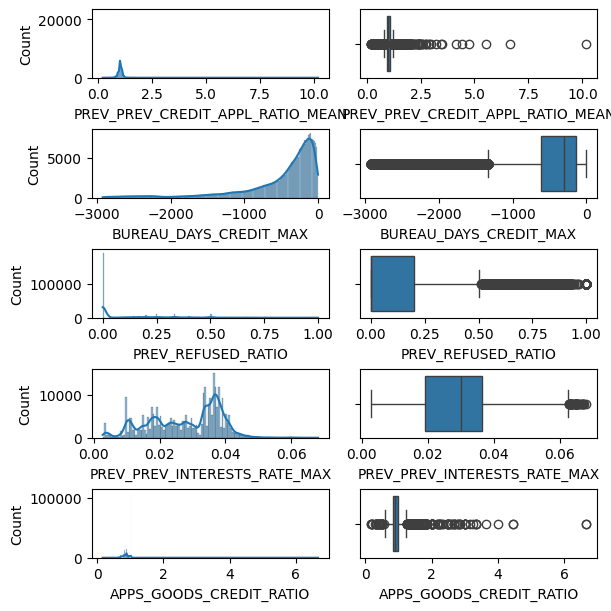

In [ ]:
# Графики распределения переменных и "ящики с усами"
float_cols = [cname for cname in apps_all.columns if apps_all[cname].dtype in ['float64']]
clmns = apps_all.columns

plot_feat = list(set(float_cols)&set(clmns)&set(most_important_features50) - set('SK_ID_CURR'))
# bureau_active_agg_cols.drop(['SK_ID_CURR'])[:5]
fig, axes = plt.subplots(5, 2, figsize=(6, 6),constrained_layout=True)
for k, column in enumerate(plot_feat[0:5]):    
    sns.histplot(data=apps_all, x=column, kde=True, ax=axes[k, 0])
    sns.boxplot(data=apps_all, x=column, ax=axes[k, 1])
# plt.tight_layout()
plt.show()

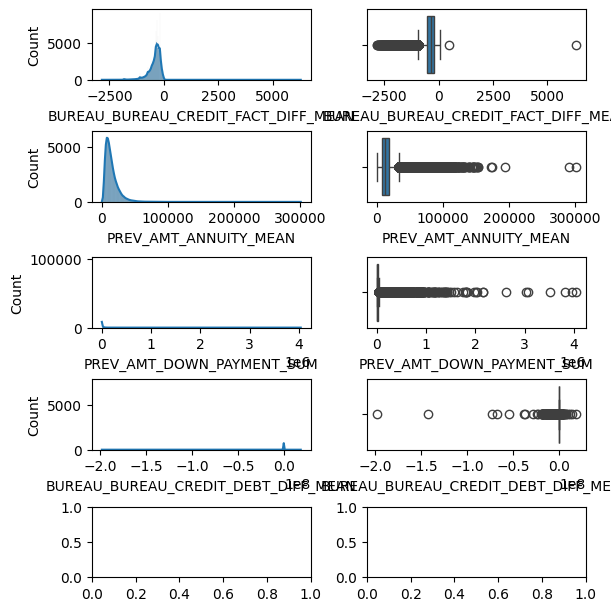

In [56]:
# Графики распределения переменных и "ящики с усами"
float_cols = [cname for cname in apps_all.columns if apps_all[cname].dtype in ['float64']]
clmns = apps_all.columns

plot_feat = list(set(float_cols)&set(clmns)&set(most_important_features50) - set('SK_ID_CURR'))
# bureau_active_agg_cols.drop(['SK_ID_CURR'])[:5]
fig, axes = plt.subplots(5, 2, figsize=(6, 6),constrained_layout=True)
for k, column in enumerate(plot_feat[6:10]):    
    sns.histplot(data=apps_all, x=column, kde=True, ax=axes[k, 0])
    sns.boxplot(data=apps_all, x=column, ax=axes[k, 1])
# plt.tight_layout()
plt.show()

In [ ]:
# Графики распределения переменных и "ящики с усами"
float_cols = [cname for cname in apps_all.columns if apps_all[cname].dtype in ['float64']]
clmns = apps_all.columns

plot_feat = list(set(float_cols)&set(clmns)&set(most_important_features50) - set('SK_ID_CURR'))
# bureau_active_agg_cols.drop(['SK_ID_CURR'])[:5]
fig, axes = plt.subplots(5, 2, figsize=(6, 6),constrained_layout=True)
for k, column in enumerate(plot_feat[10:15]):    
    sns.histplot(data=apps_all, x=column, kde=True, ax=axes[k, 0])
    sns.boxplot(data=apps_all, x=column, ax=axes[k, 1])
# plt.tight_layout()
plt.show()

In [ ]:
# Графики распределения переменных и "ящики с усами"
float_cols = [cname for cname in apps_all.columns if apps_all[cname].dtype in ['float64']]
clmns = apps_all.columns

plot_feat = list(set(float_cols)&set(clmns)&set(most_important_features50) - set('SK_ID_CURR'))
# bureau_active_agg_cols.drop(['SK_ID_CURR'])[:5]
fig, axes = plt.subplots(5, 2, figsize=(6, 6),constrained_layout=True)
for k, column in enumerate(plot_feat[15:20]):    
    sns.histplot(data=apps_all, x=column, kde=True, ax=axes[k, 0])
    sns.boxplot(data=apps_all, x=column, ax=axes[k, 1])
# plt.tight_layout()
plt.show()

In [ ]:
# Графики распределения переменных и "ящики с усами"
float_cols = [cname for cname in apps_all.columns if apps_all[cname].dtype in ['float64']]
clmns = apps_all.columns

plot_feat = list(set(float_cols)&set(clmns)&set(most_important_features50) - set('SK_ID_CURR'))
# bureau_active_agg_cols.drop(['SK_ID_CURR'])[:5]
fig, axes = plt.subplots(5, 2, figsize=(6, 6),constrained_layout=True)
for k, column in enumerate(plot_feat[20:25]):    
    sns.histplot(data=apps_all, x=column, kde=True, ax=axes[k, 0])
    sns.boxplot(data=apps_all, x=column, ax=axes[k, 1])
# plt.tight_layout()
plt.show()